# Module 3: Microbiology: Bacteria Growth using the Monod Law
### Author: Neil Tramsen
### Group Members: Duncan Guy, Bonning Xu, Deniz Parmaksiz
In this project, we develop a model for the growth a bacteria culture with a finite amount of nutrients available to it, following the Monod Law. We then use optimization algorithms to fit a curve to real life data, allowing us to determine the value of constants for the given situation, and inputting them into our computational model to determine how the bacteria culture continues developing over time.

## Problem Analysis

### Physical Considerations

There are two variables that our model will need to track: the number of bacteria, and the nutrient concentration available to the bacteria. The Monod Law defines the growth rate of the bacteria, which is proportional to the nutrient concentration. The rate of change of the nutrients is proportional the rate of change of the number of bacteria, as nutrients is metabolised to produce new bacteria cells, so the greater the rate of change of bacteria, the more bacteria are being produced, and the more quickly the nutrients is depleted.

This has a number of physical implications. Firstly, the bacteria can only grow for as long as there is nutrients available, and as soon as the initial nutrients is depleted, they will gradually die off proportional to the death rate. Furthermore, the minimum concentration of nutrients is naturally limited to 0, as when the nutrients tends towards 0, the growth rate of bacteria will tend towrds 0, and the change in nutrients is proportional to the change in number of bacteria, so the nutrient concenttration will go to 0 and then stop changing. This means that we do not need to worry about the nutrient concentration becoming negative.

There is also an initial lag time in which the bacteria are inactive as they adjust to their new environment, defined as $\tau$. This means that there is no change in nutrient concentration, and no change in the number of bacteria, other than chnages due to the death rate. However, typical death rates result in 1 or 2 bacteria dying per 100 hours for our initial conditions of around 50 bacteria and $\tau = 4.5$, so the death rate can be ignored during the lag time, and we can assume that the number of bacteria is also unchanged. For this reason, time arrays will always start at 4.5 hours, and it will be assumed that the previous 4.5 hours will have been equal to the initial conditions.

### Coding Considerations

This model is a time-dependent model, as it will track the number of bacteria and the concentration of nutrients over time, and it is deterministic as the solution is only dependent on the intial conditions and the values of the constants. This means that identical initial conditions will produce identical outputs. While the number of bacteria is technically a discrete variable, we will be treating ut as if it is continuous as we expect to see a large growth in the number of bacteria, which means that changes half a bacterial cell will be negligible. The concentration of nutrients is a truly continuous variable, as its value can be anywhere in the range of 0 to its initial concentration. To initialize the problem we will need to specifiy the value of the Monod Constant, $K$, the maximum growth rate, $g_{max}$, the death rate, $\mu$, and the rate of consumption of the nutrients, $a$, along with the initial values for the number of bacteria and the concentration of nutrients. We will be using odeint from scipy.integrate as our integrator, as it is fast with very little error.

The value for the constants of the real data will be determined using the curve_fit method from scipy.optimize. To use this algorithm, a reasonably close intial guess is required. To determine these initial guesses, we will be using least squares regression to fit lines to certain regimes of the data in which a particular constant dominates, as well as using some calculations and estimations for some of the constants that are harder to determine from regimes of the data.

## Model Development



The growth rate of the bacteria is goverened by the Monod Law, defined as: $$\frac{dn}{dt} = n\frac{g_{max}\rho}{\rho+K},$$
where $n$ is the number of bacteria, $g_max$ is related to the maximum growth rate, $\rho$ is the nutrient concentration, and $K$ is the Monod constant. The bacteria are also subject to a death rate, $\mu$. 

The rate of change of the nutrient concentration is proportional to the negative of the bacteria's growth rate, and the constant $a$, which defines a single bacterium's rate of consumption of nutrients.
$$\begin{cases}
\frac{dn}{dt} = n\frac{g_{max}\rho}{\rho+K}-\mu n,\\\frac{d\rho}{dt} = -a*n\frac{g_{max}\rho}{\rho+K}
\end{cases}$$


## Model Implementation

### Initializing Python

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

### Defining the growth function

In [2]:
def BacterialGrowth(variable, t, gmax, k, mu, a):
    """
    Calculates the rate of change in the bacteria population and the nutrient concentration.
    BacterialGrowth(variable, t, gmax, k, mu, a) 
    variable = [bacteria population, nutrient concentration] 
    """
    dn = (variable[0]*gmax*variable[1])/(variable[1]+k)-mu*variable[0]
    dp = -a*(variable[0]*gmax*variable[1])/(variable[1]+k)
    
    return np.array([dn,dp])

def BGTrajectory(t, gmax, k, mu, a):
    """
    Returns an array containing the bacteria population  and nutrient concentration over the time, t.
    BGTrajectory(t, gmax, k, mu, a) 
    """
    return odeint(BacterialGrowth, x0, t, args=(gmax, k, mu, a))

def PopulationTrajectory(t, gmax, k, mu, a):
    """
    Returns an array containing the bacteria population over the time, t.
    PopulationTrajectory(t, gmax, k, mu, a) 
    """
    return odeint(BacterialGrowth, x0, t, args=(gmax, k, mu, a))[:,0]

def LogPopulationTrajectory(t, gmax, k, mu, a):
    """
    Returns an array containing the logarithm of the bacteria population over the time, t.
    LogPopulationTrajectory(t, gmax, k, mu, a) 
    """
    return np.log(odeint(BacterialGrowth, x0, t, args=(gmax, k, mu, a))[:,0])

### Verifying parameters and intial conditions lie within constraints

In [3]:
def ParameterCheck(gmax, k, mu, a, P0):
    """
    Checks the parameters for the growth function are valid. Returns true if valid, false otherwise.
    
    ParameterCheck(gmax, a, mu, k, P0)
    
    """
    if gmax<0:
        print("Error: 'gmax' must not be less than 0.")
        return False
    if k<0:
        print("Error: 'k' must not be less than 0.")
        return False
    if mu<0:
        print("Error: 'mu' must not be less than 0.")
        return False
    if a<0:
        print("Error: 'a' must not be less than 0.")
        return False
    if P0[0]<0:
        print("Error: initial number of bacteria must not be less than 0.")
        return False
    if P0[1]<0:
        print("Error: initial nutrient concentration must not be less than 0.")
        return False
    return True   

### Testing the model

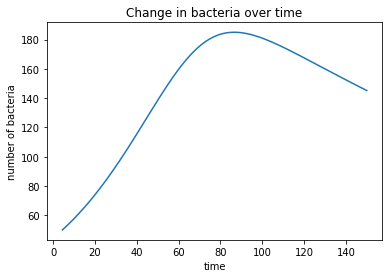

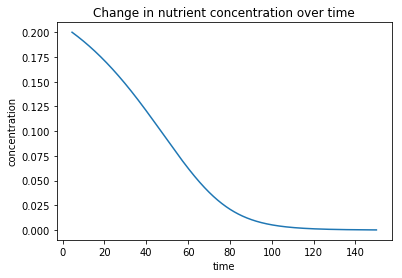

In [4]:
#initialising parameters and initial conditions
x0 = np.array([50,0.2])
gmax = 0.05
k = 0.122
mu = 0.005
a = 10**(-3)

Time = 150
dt = 0.1

t = np.arange(4.5,Time+dt, dt)

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

    plt.plot(t, result[:,1])
    plt.xlabel("time")
    plt.ylabel("concentration")
    plt.title("Change in nutrient concentration over time")
    plt.show()

As expected, the bacteria population grows until the nutrient concentration reaches 0, at hich point there is no nutrients to produce more bacteria, and the population gradually dies off at its death rate, $\mu$.

## Model verification

### No initial bacteria

If the initial bacteria population is 0, there are no bacteria to grow the population, so the population should stay at 0 over the time period.

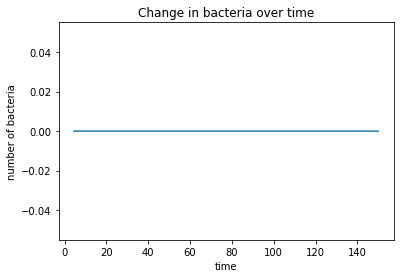

In [5]:
x0 = np.array([0,0.2])

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

### No initial food

If the initial nutrient concentration is 0, we expect the bacteria population to decrease exponentially at a rate of $-\mu$.

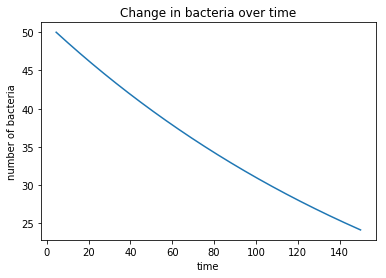

In [6]:
x0 = np.array([50,0])

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

### No growth rate

The growth rate of the bacteria is defined as $\frac{dn}{dt} = n\left(\frac{g_{max}\rho}{\rho+K}-\mu\right).$ Setting $\frac{dn}{dt}$ equal to 0, we can rearrange the equation to determine that $p=\frac{K*\mu}{g_{max}-\mu}$. At this concetration, the initial value for $\frac{dn}{dt}$ will be 0, but over time the bacteria population will still decrease, as bacteria have to be produced to equal the death rate, meaning that nutrients is used and decreases over time. This causes the growth rate to become negative, and the population to decrease.

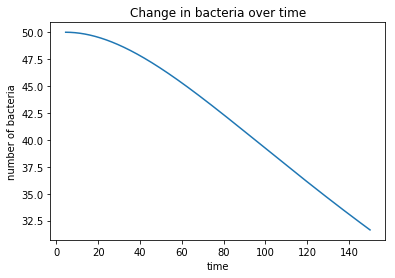

In [7]:
p = (k*mu)/(gmax-mu)

x0 = np.array([50,p])

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

### No death

Setting the death rate to 0 should cause the bacteria population to increase until the nutrient concentration reaches 0, at which point the bacteria population should remain constant.

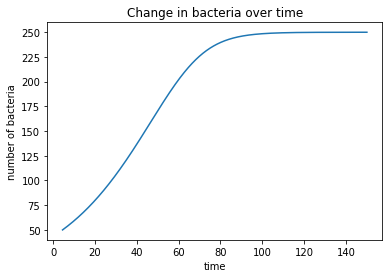

In [8]:
x0 = np.array([50,0.2])

mu = 0

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

### Unlimited food

Setting $a$, the amount of nutrients consumed to produce a single bacterium, to 0 means that the nutrient concentration doesn't decrease, instead remaining constant, allowing the bacteria population to increase exponentially.

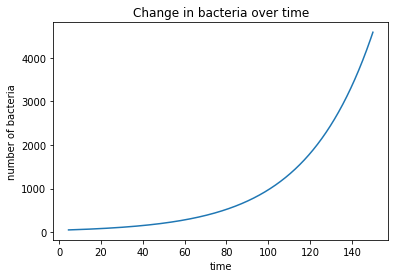

In [9]:
x0 = np.array([50,0.2])
a = 0

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

### Saturation

The growth rate of the bacteria saturates, as $\frac{dn}{dt} = n\left(\frac{g_{max}\rho}{\rho+K}-\mu\right),$ so when $\rho$ is much greater than $K$, the growth rate is just $g_{max}$, which is constant. So as the initial concentration increase, the initial growth rate increases, until it begins to level off as the growth rate becomes saturated.

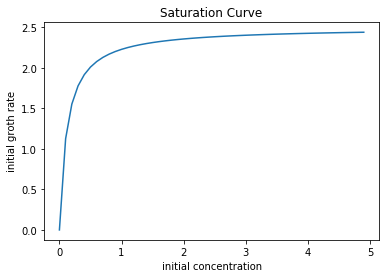

In [10]:
# saturation curve
dn = np.zeros(50)
p = np.arange(0,5,0.1)
for i in range(50):
    x0 = np.array([50,p[i]])
    dn[i] = BacterialGrowth(x0, 0, gmax, k, mu, a)[0]

plt.plot(p, dn)
plt.xlabel("initial concentration")
plt.ylabel("initial groth rate")
plt.title("Saturation Curve")
plt.show()

## Applying Model to real life data

Now that the model is verified, we can apply it to real life data. In this next section, we will import real data from a file, use numpy's least squares regression and a little algebra to estimate the parameters, and then use curve_fit for a more accurate estimate of the parameters. We can then input these parameters into our original function, to see how the bacteria population would have continued developing beyond the times in the data.

### Importing data

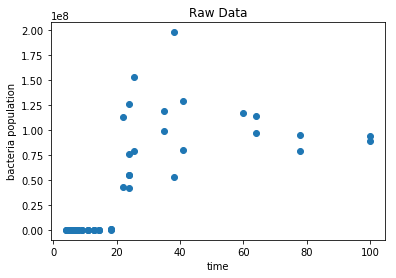

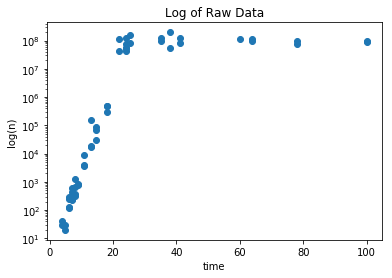

In [11]:
directory = r"C:\Users\HP\Documents\Emory\Semester 4\phys 212\Module 3"
data = np.loadtxt(directory+"\Bacteria.txt",delimiter = ",")

data = np.array(data)
order = np.argsort(data, axis = 0) #argsort generates an array of indexes that would sort the inout array
n = np.array(data)[order[:,0],:] #sorts the array based on argsort's array of indexes

plt.plot(n[:,0], n[:,1], 'o')
plt.xlabel("time")
plt.ylabel("bacteria population")
plt.title("Raw Data")
plt.show()

plt.semilogy(n[:,0], n[:,1], 'o')
plt.xlabel("time")
plt.ylabel("log(n)")
plt.title("Log of Raw Data")
plt.show()

### Using least squares regression to determine estimates of constants

In [12]:
#guess using linear fit of first part of data

first_range = 30
t = n[:,0][0:first_range]
x = t.reshape((t.size, 1))
y = np.log(n[:,1][0:first_range])
y = y.reshape((y.size, 1))

a = float(np.linalg.lstsq(x, y, rcond=None)[0])
v_guess = a
print('Estimated V=' + str(v_guess))

Estimated V=0.7630870932310448


The first 30 points have a very constant, positive gradient on the log graph. From this, we can assume that $\rho$, the nutrient concentration, is reasonably bigger than $K$, the Monod constant, due to the constant increase. This means that the gradient of the first 30 points is approximately equal to $g_{max}$, and so serves as a reasonable initial guess for $g_{max}$ when using curve_fit. We can also make the initial guess that $K$ is much less than $\rho_{initial}=0.2$, so a value of 10% was chosen so that the guess for $K$ is 0.02. As this is just an initial guess, any inaccuracies shouldn't have a large effect.

In [13]:
#guess using linear fit of second part of data

last_range = 13
t = n[:,0][-last_range:]
x = np.vstack((np.ones(t.size),t)).T
y = np.log(n[:,1][-last_range:])
y = y.reshape((y.size, 1))
a,b = np.linalg.lstsq(x, y, rcond=None)[0]
k_guess = b
print('Estimated k=' + str(k_guess))

Estimated k=[-0.00256556]


The last 13 points have a very constant, negative gradient on the log graph. In our model, the gradient becomes negative when the nutrient concentration is 0, and the only thing affecting the bacteria population is the death rate. So the gradient of the last 13 points should be a good estimate for $-\mu$.

The only constant we cannot determine directly from the gradients in the data is $a$, the amount of nutrients consumed to produce 1 bacterium. However, we see that the population reaches around $2*10^8$ bacteria at its maximum, when $\rho$ is approximately 0. This means that $2*10^8$ bacteria were produced using 0.2 micrograms per millilitre of nutrients, so we can estimate $a$ to be equal to $\frac{0.2}{2*10^8}$, which is around $10^{-9}$.

### Using curve_fit to determine accurate value of constants

0.9532030238271036 1.499407687098783 0.003673886586089129 4.1183264342856163e-08


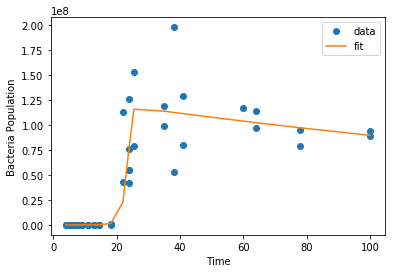

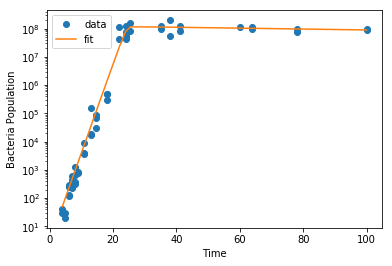

Fitted a = 4.1183264342856163e-08
Fitted K = 1.499407687098783
Fitted mu = 0.003673886586089129
Fitted gmax = 0.9532030238271036


In [14]:
gmax_guess = 0.7630870932310448
K_guess = 0.02
mu_guess = 0.00256556
a_guess = 10**(-9)

t = n[:,0]
population = n[:,1]

gmax, K, mu, a = curve_fit(PopulationTrajectory,t, population, p0=(gmax_guess, K_guess, mu_guess, a_guess), bounds=((0, 0, 0, -np.inf), (1000, 1.5, 1, np.inf)))[0]

print(gmax, K, mu, a)

plt.plot(n[:,0], n[:,1], 'o', label='data')
plt.plot(n[:,0], PopulationTrajectory(n[:,0], gmax, K, mu, a), label='fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bacteria Population')
plt.show()

plt.semilogy(n[:,0], n[:,1], 'o', label='data')
plt.semilogy(n[:,0], PopulationTrajectory(n[:,0], gmax, K, mu, a), label='fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bacteria Population')
plt.show()

print('Fitted a = ' + str(a))
print('Fitted K = ' + str(K))
print('Fitted mu = ' + str(mu))
print('Fitted gmax = ' + str(gmax))

The values for the parameters all seem reasonable. In an attempt to confirm them, the process was repeated on the log of the data, which should produce slightly more accurate values as the variance in some of the data points is smaller. However, as can be seen below, the value for $K$ is very different. This suggests that the value for $K$ is not closely linked to any of the gradients in this data, and also that it probably doesn't make a huge difference to the fits.

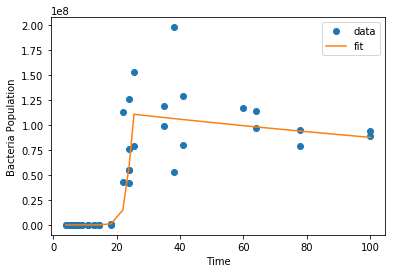

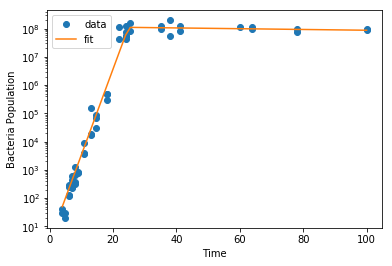

Fitted a = 4.3940646864472855e-08
Fitted K = 0.08943788785820621
Fitted mu = 0.003142550191815141
Fitted gmax = 0.7163619763857495


In [15]:
gmax_guess = 0.7630870932310448
K_guess = 0.02
mu_guess = 0.0026
a_guess = 10**(-9)

t = n[:,0]
population = n[:,1]

gmax, K, mu, a = curve_fit(LogPopulationTrajectory,t, np.log(population), p0=(gmax_guess, K_guess, mu_guess, a_guess), bounds=((0, 0, 0, -np.inf), (1000, 1.5, 1, np.inf)))[0]

plt.plot(n[:,0], n[:,1], 'o', label='data')
plt.plot(n[:,0], PopulationTrajectory(n[:,0], gmax, K, mu, a), label='fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bacteria Population')
plt.show()

plt.semilogy(n[:,0], n[:,1], 'o', label='data')
plt.semilogy(n[:,0], PopulationTrajectory(n[:,0], gmax, K, mu, a), label='fit')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bacteria Population')
plt.show()

print('Fitted a = ' + str(a))
print('Fitted K = ' + str(K))
print('Fitted mu = ' + str(mu))
print('Fitted gmax = ' + str(gmax))

We can now use our values from the fitting to run our original function, and can see how this population would have developed over time, extrapolating from this data.

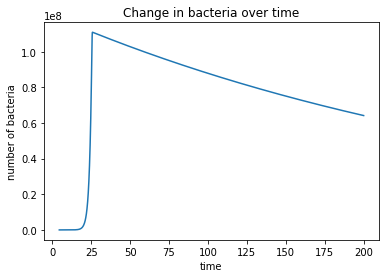

In [16]:
Time = 200
dt = 0.1

t = np.arange(4.5,Time+dt, dt)

if ParameterCheck(gmax, k, mu, a, x0):
    result = BGTrajectory(t, gmax, k, mu, a)

    plt.plot(t, result[:,0])
    plt.xlabel("time")
    plt.ylabel("number of bacteria")
    plt.title("Change in bacteria over time")
    plt.show()

## Conclusions

The Monod Law provides a reasonable model for bacteria growth, with our implementation of the model exhibiting all the expected behaviours, as shown in our verification steps. We were then able to apply this model to a real set of data, using the optimization algorithm curve_fit to deterimine the values for the parameters for that real set of data. We were then able to rerun our model using the data's parameters, to extrapolate and see how the bacteria population would have developed over a longer time. The steps used in this project could be applied to a number of different bacteria cultures, allowing it be described in terms of the constants used in the Monod Law.